In [30]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
# import json
from tqdm import tqdm

# import numpy as np
from scipy.sparse import lil_matrix

## New laplacian code

In [31]:
def create_laplacian_matrix(n):
    # Total number of grid points
    total_points = n * n

    laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

# Example usage
grid_size = 3  # Change this value to adjust the grid size
laplacian_matrix = create_laplacian_matrix(grid_size)

print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])


## Rewrite the original code using torch

In [32]:

# Simulating the TDGL equation
a, b, k = -1.0, 1.0, 100.0 #configuração: (a<0, b>0) ou (a>0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 64, 10001

a = torch.tensor(a, device='cpu')
b = torch.tensor(b, device='cpu')
k = torch.tensor(k, device='cpu')
dh = torch.tensor(dh, device='cpu')
dt = torch.tensor(dt, device='cpu')
Ng = torch.tensor(Ng, device='cpu')
Tf = torch.tensor(Tf, device='cpu')
T = torch.tensor([0.5], device='cpu')

# Ng, Tf = 64, 10001
master_list = []


def laplacian(n):
    # Total number of grid points
    total_points = n * n

    matrix_laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            matrix_laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                matrix_laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                matrix_laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                matrix_laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                matrix_laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

def integrate(L, u):
    '''  simulates the equation and plots it at different instants '''

    #f = plt.figure(figsize=(15, 15), dpi=80);

    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cpu')
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method

        # if (i==0):      configPlot(x, y, u, f, 1, i);
        # if (i==1):      configPlot(x, y, u, f, 2, i);
        # if (i==10):     configPlot(x, y, u, f, 3, i);
        # if (i==100):    configPlot(x, y, u, f, 4, i);
        # if (i==1000):   configPlot(x, y, u, f, 5, i);
        if (i==10000):
            master_list.append(u)
            #configPlot(x, y, u, f, 6, i)


def configPlot(x, y, u,f, n_, i):
    u = u.view((Ng, Ng))
    u = u.cpu()
    U = u.numpy()
    sp =  f.add_subplot(3, 3, n_ )
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)
    plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i)


In [34]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')


x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais

#L = L.to_dense()
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
N_real = 50
for realization in tqdm(range(N_real), desc="Processing", ncols=100, ascii=True):
# for i in range(20):
  u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
  integrate(L, u)    # simulate
  if realization % 5 ==0:
    print(f'Realization: {realization}')


## salva estas configurações em um arquivo JSON

# mlist = [[] for _ in range(5)]
# num = 0
# for l in master_list:
#     l = l.cpu()
#     for i in range(len(l)):
#         mlist[num].append(l[i].item())
#     num+=1

# file_path = 'data_configs_a_pos_b_pos.json'

# with open(file_path, 'w') as json_file:
#    json.dump(mlist, json_file)

Processing:   2%|#                                                   | 1/50 [00:11<09:35, 11.74s/it]

Realization: 0


Processing:  12%|######2                                             | 6/50 [01:04<07:45, 10.58s/it]

Realization: 5


Processing:  22%|###########2                                       | 11/50 [02:05<08:06, 12.48s/it]

Realization: 10


Processing:  32%|################3                                  | 16/50 [03:00<05:58, 10.54s/it]

Realization: 15


Processing:  42%|#####################4                             | 21/50 [03:45<04:23,  9.09s/it]

Realization: 20


Processing:  52%|##########################5                        | 26/50 [04:25<03:18,  8.29s/it]

Realization: 25


Processing:  62%|###############################6                   | 31/50 [05:06<02:35,  8.19s/it]

Realization: 30


Processing:  72%|####################################7              | 36/50 [05:48<01:57,  8.42s/it]

Realization: 35


Processing:  82%|#########################################8         | 41/50 [06:30<01:14,  8.31s/it]

Realization: 40


Processing:  92%|##############################################9    | 46/50 [07:11<00:32,  8.19s/it]

Realization: 45


Processing: 100%|###################################################| 50/50 [07:46<00:00,  9.33s/it]


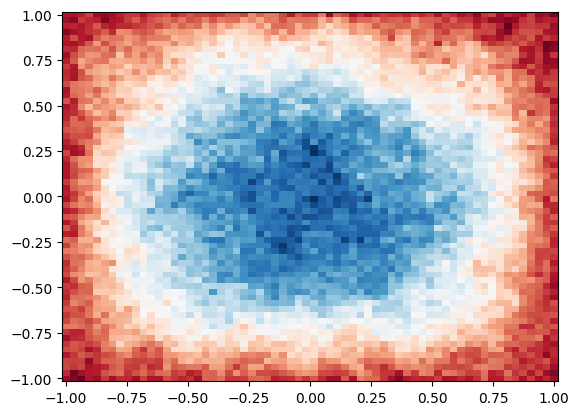

In [35]:
## visualizar a configuração final individualmente

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

u = master_list[34]
u = u.view((Ng, Ng))
u = u.cpu()
U = u.numpy()

plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu)
plt.show()

## Calculate the mean of configurations

Processing: 100%|#############################################| 4096/4096 [00:02<00:00, 1815.78it/s]


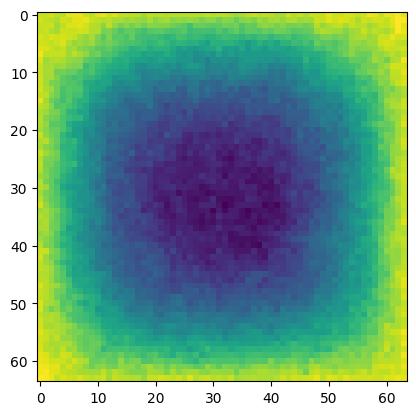

In [36]:
mean_config = []
size = len(master_list)
N = 64*64
temp = 0

# for i in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True): #range(N):
    for config in range(size):
        temp += master_list[config][point]
    mean_config.append(temp/size)
    temp = 0

mean_config = torch.tensor(mean_config)
mean_config = mean_config.view((Ng, Ng))
plt.imshow(mean_config)
plt.show()

Processing: 100%|#############################################| 4096/4096 [00:01<00:00, 2649.83it/s]


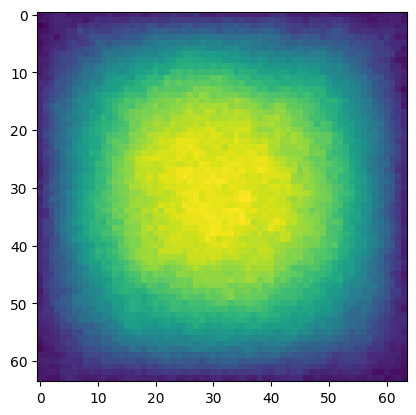

In [14]:
mean_config = []
size = len(master_list)
N = 64*64
temp = 0

# for i in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True): #range(N):
    for config in range(size):
        temp += master_list[config][point]
    mean_config.append(temp/size)
    temp = 0

mean_config = torch.tensor(mean_config)
mean_config = mean_config.view((Ng, Ng))
plt.imshow(mean_config)
plt.show()

In [ ]:
def media_final(mean_config, Ng):
    sum = 0 
    for x in range(Ng):
        for y in range(Ng):
            sum = sum + mean_config[x][y]
    return sum / (Ng*Ng)

media_final(mean_config, Ng)

In [37]:
sum = 0 
for x in range(Ng):
    for y in range(Ng):
        sum = sum + mean_config[x][y]

sum / (Ng*Ng)

tensor(-0.1071)